# NLP name classifier

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

In [1]:
# load data from file and prepare data
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"  # all characters
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def letterToTensorGRU(letter):  
    tensor = torch.zeros(1, 1, n_letters)  # input dimension need to be (batch_size, seq_len, input_size)
    tensor[0][0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def lineToTensorGRU(line):  
    tensor = torch.zeros(1, len(line), n_letters)  # input dimension need to be (batch_size, seq_len, input_size)
    for li, letter in enumerate(line):
        tensor[0][li][letterToIndex(letter)] = 1
    return tensor

def lineToInputGRU(line_oh):  
    tensor = torch.zeros(1, 1, n_letters)  # input dimension need to be (batch_size, seq_len, input_size)
    for li, letter_oh in enumerate(line_oh):
        tensor[0][0][li] = letter_oh
    return tensor

#print(letterToTensor('J'))

#print(lineToTensor('Jones').size())

print(letterToTensorGRU('J').size())

print(lineToTensorGRU('Jones').size())
print(lineToTensorGRU('Jones'))

torch.Size([1, 1, 57])
torch.Size([1, 5, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## RNN

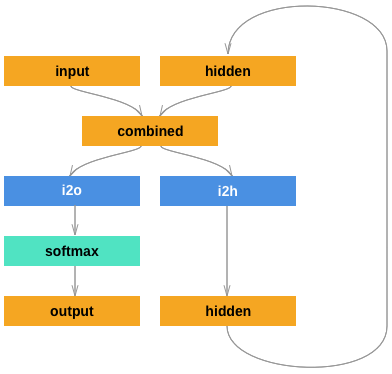

In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # input to output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)  # simply concatenate
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

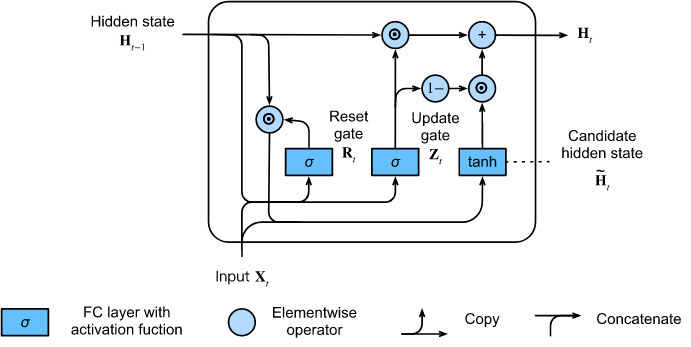

In [85]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, drop_prob=0.1):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers, batch_first=True, dropout=drop_prob)
        self.hidden2tag = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, input, hidden):  
        output, hidden = self.gru(input, hidden)
        output = self.hidden2tag(self.relu(output[:,-1]))  # all rows, only last col of output
        return output, hidden

    def initHidden(self, batch_size, device):
        weight = next(self.parameters()).to(device).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden

n_hidden = 128
rnn = GRU(n_letters, n_hidden, n_categories, 3) # input dimension need to be (batch_size, seq_len, input_size)
rnn.to('cuda:0')

GRU(
  (gru): GRU(57, 128, num_layers=3, batch_first=True, dropout=0.1)
  (hidden2tag): Linear(in_features=128, out_features=18, bias=True)
  (relu): ReLU()
)

In [86]:
input = letterToTensorGRU('A').to('cuda:0')  # input dimension need to be (batch_size, seq_len, input_size)
hidden = torch.zeros(3, 1, n_hidden).to('cuda:0')

output, next_hidden = rnn(input, hidden)  # one single step
print(output)

tensor([[-0.0550, -0.0726,  0.0494,  0.0624, -0.0498, -0.0021, -0.0292,  0.0696,
          0.0758,  0.0050,  0.0997, -0.0341,  0.0918, -0.0050, -0.0635, -0.0773,
          0.0217, -0.0377]], device='cuda:0', grad_fn=<AddmmBackward>)


In [87]:
name = 'Albert'
input = lineToTensorGRU(name).to('cuda:0')
hidden = torch.zeros(3, 1, n_hidden).to('cuda:0')

print(input.size())

output, next_hidden = rnn(input, hidden)  # run a single step through the rnn
print(output)

torch.Size([1, 6, 57])
tensor([[-0.0514, -0.0726,  0.0770,  0.0836, -0.0769, -0.0023, -0.0251,  0.0550,
          0.0448,  0.0186,  0.1339, -0.0518,  0.1090,  0.0092, -0.0753, -0.0925,
          0.0183, -0.0382]], device='cuda:0', grad_fn=<AddmmBackward>)


In [88]:
def categoryFromOutput(output):
    '''to interpret the output of the network'''
    top_n, top_i = output.topk(1)  # get the index of the greatest value
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


In [115]:
# to get a quick training example
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)  # choose language
    line = randomChoice(category_lines[category])  # choose line
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # build category tensor
    line_tensor = lineToTensor(line)  # build line tensor
    return category, line, category_tensor, line_tensor

def randomTrainingExampleGRU():
    category = randomChoice(all_categories)  # choose language
    line = randomChoice(category_lines[category])  # choose line
    category_tensor = torch.tensor([[1 if i == all_categories.index(category) else 0 for i in range(len(all_categories))]], dtype=torch.long)  # build category tensor
    line_tensor = lineToTensorGRU(line)  # build line tensor
    return category, line, category_tensor, line_tensor

print(all_categories)

for i in range(3):
    category, line, category_tensor, line_tensor = randomTrainingExampleGRU()
    print('category =', category, '/ line =', line)
    print(line_tensor[0][0])
    print(category_tensor)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
category = Arabic / line = Srour
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
category = Russian / line = Martyshin
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
category = Greek / line = Horiatis
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [135]:
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn

#criterion = nn.NLLLoss()  # init loss function
criterion = nn.MSELoss()  # init loss function
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):  # Create target (=category_tensor) and input (=line_tensor) tensors
    hidden = rnn.initHidden(1, 'cuda:0')  # Create a zeroed initial hidden state

    rnn.zero_grad()

    output, hidden = rnn(line_tensor.to('cuda:0').float(), hidden)  # Keep hidden state for next letter

    loss = criterion(output, category_tensor.to('cuda:0').float())  # Compare final output to target
    loss.backward()  # Back-propagate
    optimizer.step()

    return output, loss.item()  # Return the output and loss

In [136]:
import time
import math

n_iters = 10000
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExampleGRU()  # fetch a random example
    output, loss = train(category_tensor, line_tensor)  # train
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 1s) 0.0703 An / German ✗ (Vietnamese)
1000 10% (0m 3s) 0.0613 Adigamoff / Portuguese ✗ (Russian)
1500 15% (0m 5s) 0.0929 Lamberti / Greek ✗ (Italian)
2000 20% (0m 7s) 0.0579 Voclain / Irish ✗ (French)
2500 25% (0m 8s) 0.0569 Michael / German ✗ (Irish)
3000 30% (0m 10s) 0.0711 Than / Arabic ✗ (Vietnamese)
3500 35% (0m 12s) 0.0595 Daher / Polish ✗ (Arabic)
4000 40% (0m 14s) 0.0777 Zawisza / Greek ✗ (Polish)
4500 45% (0m 15s) 0.0750 Arrigucci / Vietnamese ✗ (Italian)
5000 50% (0m 17s) 0.0408 Kleid / Russian ✗ (German)
5500 55% (0m 19s) 0.0775 Snider / German ✗ (Dutch)
6000 60% (0m 21s) 0.0543 Sala / Czech ✗ (Italian)
6500 65% (0m 23s) 0.0514 Rothbauer / Vietnamese ✗ (German)
7000 70% (0m 24s) 0.0554 Doan / Irish ✗ (Vietnamese)
7500 75% (0m 26s) 0.0625 Sinclair / Chinese ✗ (Scottish)
8000 80% (0m 28s) 0.0497 Fonseca / Russian ✗ (Portuguese)
8500 85% (0m 30s) 0.0711 Quraishi / Portuguese ✗ (Arabic)
9000 90% (0m 31s) 0.0705 Lu / Russian ✗ (Chinese)
9500 95% (0m 33s) 0.0798 Eatros 

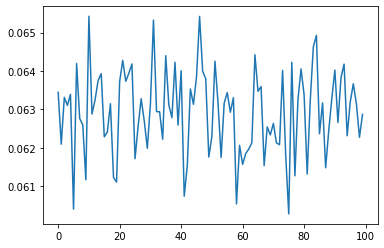

In [137]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


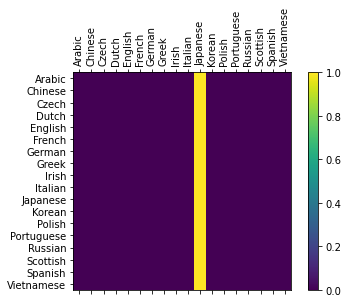

In [125]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden(1, 'cuda:0') 

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor.to('cuda:0'), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExampleGRU()  # fetch a random example
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)  # category of guess
    category_i = all_categories.index(category)  # correct category
    confusion[category_i][guess_i] += 1  # increment counter at correct and guessed category

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [37]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensorGRU(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Bernd')
predict('Patrick')
predict('Aurelia')
predict('Jakob')


> Dovesky
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Jackson
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Satoshi
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Bernd
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Patrick
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Aurelia
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese

> Jakob
(1.13) Arabic
(0.02) Irish
(0.00) Vietnamese


## Exercises
- Try with a different dataset of line -> category, for example:
 - Any word -> language
 - First name -> gender
 - Character name -> writer
 - Page title -> blog or subreddit
- Get better results with a bigger and/or better shaped network
 - Add more linear layers
 - Try the nn.LSTM and nn.GRU layers
 - Combine multiple of these RNNs as a higher level network

In [10]:
# https://blog.floydhub.com/gru-with-pytorch/

import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

# Define data root directory
data_dir = r'C:\Users\bscho\Documents\DL\data\poweruse'

os.chdir(data_dir)
# Visualise how our data looks
pd.read_csv(r'AEP_hourly.csv').head()

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(data_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv('{}/{}'.format(data_dir, file), parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [11]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True).__iter__()

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [12]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [13]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(train_loader)[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            
            print(x.size())
            print(x)
            break
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
        
        break
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [14]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
#Lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of GRU model
torch.Size([1024, 90, 5])
tensor([[[0.4269, 0.2609, 0.0000, 0.0909, 0.0904],
         [0.5054, 0.3043, 0.0000, 0.0909, 0.0904],
         [0.5582, 0.3478, 0.0000, 0.0909, 0.0904],
         ...,
         [0.6252, 0.9130, 0.5000, 0.0909, 0.0986],
         [0.6089, 0.9565, 0.5000, 0.0909, 0.0986],
         [0.5713, 1.0000, 0.5000, 0.0909, 0.0986]],

        [[0.6135, 0.9565, 0.3333, 0.6364, 0.6630],
         [0.5557, 1.0000, 0.3333, 0.6364, 0.6630],
         [0.4912, 0.0000, 0.5000, 0.7273, 0.6658],
         ...,
         [0.4994, 0.5652, 1.0000, 0.7273, 0.6740],
         [0.5127, 0.6087, 1.0000, 0.7273, 0.6740],
         [0.5243, 0.6522, 1.0000, 0.7273, 0.6740]],

        [[0.1919, 0.2174, 0.0000, 0.6364, 0.6110],
         [0.2158, 0.2609, 0.0000, 0.6364, 0.6110],
         [0.2769, 0.3043, 0.0000, 0.6364, 0.6110],
         ...,
         [0.5387, 0.8696, 0.5000, 0.6364, 0.6192],
         [0.5456, 0.9130, 0.5000, 0.6364, 0.6192],
         [0.5329, 0.9565, 0.50

C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [80]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Evaluation Time: 1.783071600002586
sMAPE: 0.4008307104832169%


C:\Users\bscho\anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

NameError: name 'lstm_outputs' is not defined

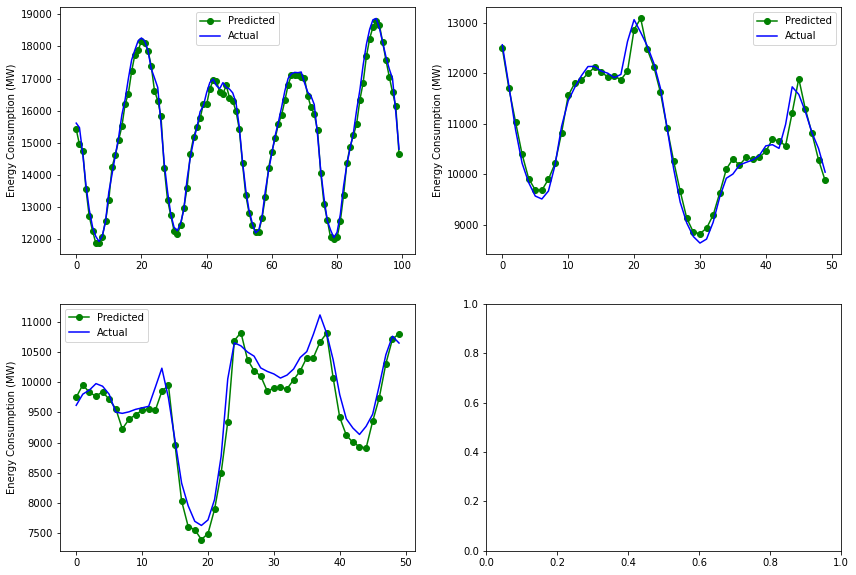

In [81]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="g", label="Predicted")
plt.plot(targets[8][-50:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(lstm_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(targets[6][:100], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

In [ ]:
# https://d2l.ai/chapter_recurrent-modern/gru.html

In [ ]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [4]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


In [6]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [7]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [8]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.1389, -1.2024, -0.9693],
        [-1.1065, -1.2200, -0.9834],
        [-1.1286, -1.2093, -0.9726],
        [-1.1190, -1.1960, -0.9916],
        [-1.0137, -1.2642, -1.0366]])
tensor([[-0.0462, -4.0106, -3.6096],
        [-4.8205, -0.0286, -3.9045],
        [-3.7876, -4.1355, -0.0394],
        [-0.0185, -4.7874, -4.6013],
        [-5.7881, -0.0186, -4.1778]])


In [4]:
import torch

rnn = nn.GRU(10, 20, 2)  # input_size, hidden, num_layers
input = torch.randn(5, 3, 10)  # batch_size, seq_len, input_size
h0 = torch.randn(2, 3, 20)  # num_layers * num_directions, batch, hidden_size
output, hn = rnn(input, h0)  # out: seq_len, batch, num_directions * hidden_size, hn: num_layers * num_directions, batch, hidden_size
print(output)

tensor([[[ 2.5659e-01, -6.0563e-02, -2.9562e-01,  4.4534e-01,  5.7759e-01,
          -7.5750e-01, -3.0271e-01, -4.8029e-01,  5.0939e-01, -1.7019e-01,
          -1.4085e-01,  5.6438e-01,  5.6402e-01, -1.5547e-01, -4.3570e-01,
          -1.3902e-01,  2.1234e-01,  2.5165e-01,  6.5038e-01, -5.6648e-01],
         [ 8.4474e-01, -5.3987e-01, -7.2602e-02, -4.2141e-01, -1.4315e-01,
          -1.1369e+00,  6.1455e-01,  7.9089e-01,  3.2985e-02, -7.9022e-01,
          -3.1150e-01, -5.4499e-03, -4.6394e-02,  1.0305e-01,  5.4947e-01,
          -9.8161e-03,  3.0000e-01, -7.1129e-01, -1.7547e-01,  4.6966e-01],
         [-3.2930e-01,  4.0790e-01, -3.4544e-02,  1.0289e-01, -3.6906e-01,
           1.6226e+00,  1.9433e-01,  6.8703e-02, -4.7362e-01,  5.6485e-01,
           7.3549e-01,  4.0491e-01, -4.5796e-01,  1.8255e+00, -5.7419e-02,
           1.0907e+00,  8.2214e-01, -2.4675e-01,  5.2914e-01,  3.7236e-01]],

        [[ 2.7194e-01,  1.5293e-01, -3.1253e-01,  3.6232e-01,  1.1535e-01,
          -3.8898e-0

In [5]:
def one_hot(ch, vocab_size):
    return [1 if idx == char_to_ix[ch] else 0 for idx in range(vocab_size)]

p = 12
inputs = torch.tensor([[one_hot(ch, vocab_size) for ch in data[p:p+seq_length]]], dtype=torch.long)

print(inputs.size())
print(inputs)

batch_size = 3
inputs = torch.tensor([[one_hot(ch, vocab_size) for ch in data[b*seq_length+p:b*seq_length+p+seq_length]] for b in range(batch_size)], dtype=torch.long)

print(inputs.size())
print(inputs)

torch.Size([1, 7, 21])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])
torch.Size([3, 7, 21])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [9]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [12]:
class GRUTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(GRUTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The GRU takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.gru = nn.GRU(embedding_dim, hidden_dim)  # GRU: input_size, hidden, num_layers

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        gru_out, _ = self.gru(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(gru_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [22]:
model = GRUTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

ix_to_word = { w:i for i, w in enumerate(word_to_ix) }
ix_to_tag = { i:t for t, i in tag_to_ix.items() }

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)
    
    top_value, top_idx = tag_scores.topk(1)  # chose top value from scores (returned as value, idx)
    for i in top_idx:
        print(ix_to_tag[i.item()])

tensor([[-1.2383, -1.1588, -0.9257],
        [-1.2729, -1.0460, -0.9980],
        [-1.3513, -1.1436, -0.8617],
        [-1.3635, -1.1146, -0.8766],
        [-1.2866, -1.1087, -0.9319]])
tensor([[-1.3050e-02, -4.5937e+00, -5.8606e+00],
        [-5.5351e+00, -5.2276e-03, -6.6704e+00],
        [-4.7625e+00, -4.6057e+00, -1.8713e-02],
        [-1.5795e-02, -5.2453e+00, -4.5661e+00],
        [-4.9098e+00, -1.0802e-02, -5.6929e+00]])
DET
NN
V
DET
NN


# GRU next character guessing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
# https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input_embd = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input_embd)

tensor([[[-1.6095, -0.1002, -0.6092],
         [-0.9798, -1.6091, -0.7121],
         [-0.2223,  1.6871, -0.3206],
         [-0.2993,  1.8793, -0.0721]],

        [[-0.2223,  1.6871, -0.3206],
         [ 0.3037, -0.7773, -0.2515],
         [-0.9798, -1.6091, -0.7121],
         [-0.0288,  2.3571, -1.0373]]], grad_fn=<EmbeddingBackward>)

In [18]:
import string

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

data_in = input('enter some name ideas:').lower()

training_data = data_in.split(' ')

char_vocab = ["<EOS>"] + sorted([ch for ch in string.ascii_lowercase])
char_size = len(char_vocab)
char_to_ix = {ch:i for i, ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch, i in char_to_ix.items()}            

word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for word in training_data:
    if word not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)

#EMBEDDING_DIM = 6
#HIDDEN_DIM = 6

enter some name ideas:This is faster than replace with each char but wont perform as well as non pure python approaches such as regexes or string translate as you can see from the below timings For this type of problem doing it at as low a level as possible pays off
{'this': 0, 'is': 1, 'faster': 2, 'than': 3, 'replace': 4, 'with': 5, 'each': 6, 'char': 7, 'but': 8, 'wont': 9, 'perform': 10, 'as': 11, 'well': 12, 'non': 13, 'pure': 14, 'python': 15, 'approaches': 16, 'such': 17, 'regexes': 18, 'or': 19, 'string': 20, 'translate': 21, 'you': 22, 'can': 23, 'see': 24, 'from': 25, 'the': 26, 'below': 27, 'timings': 28, 'for': 29, 'type': 30, 'of': 31, 'problem': 32, 'doing': 33, 'it': 34, 'at': 35, 'low': 36, 'a': 37, 'level': 38, 'possible': 39, 'pays': 40, 'off': 41}


In [13]:
print(char_vocab)

['<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [22]:
def one_hot(input_seq, vocab_len):
    x = torch.zeros([1, len(input_seq), vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    for t in range(len(input_seq)):
        x[0][t][char_to_ix[input_seq[t]]] = 1
    return x

def one_hot_char(input_char, vocab_len):
    x = torch.zeros([1, 1, vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    x[0][0][char_to_ix[input_char]] = 1
    return x
    
print(char_vocab)

print(one_hot('brown', len(char_vocab)))
            
print(one_hot_char('b', len(char_vocab)))

EMBEDDING_DIM = len(char_vocab)
HIDDEN_DIM = 6

embedding = nn.Embedding(EMBEDDING_DIM, EMBEDDING_DIM)  # Embedding(size of the dictionary of embeddings, size of each embedding vector)
input_embd = one_hot('brown', len(char_vocab))
embedding(input_embd)

['<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.FloatTensor instead (while checking arguments for embedding)

In [23]:
class GRUCreator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, char_size):  # input dimension need to be (batch_size, seq_len, input_size)
        super(GRUCreator, self).__init__()
        self.hidden_dim = hidden_dim

        #self.word_embeddings = nn.Embedding(char_size, embedding_dim)  # lookup table that stores embeddings of a fixed dict and size
        #self.gru = nn.GRU(embedding_dim, hidden_dim)  # GRU: input_size, hidden, num_layers
        self.gru = nn.GRU(embedding_dim, hidden_dim)  # requires float inputs (so without embeddings need to cast to float)

        # The linear layer that maps from hidden state space to vocabulary space
        self.hidden2char = nn.Linear(hidden_dim, char_size)

    def forward(self, inpt):
        #embeds = self.word_embeddings(inpt)
        #print(inpt.size(), embeds.size())
        #gru_out, _ = self.gru(embeds.view(1, 1, len(inpt)))  # embeds.view(len(sentence), 1, -1)
        #print(inpt.dtype, inpt.size(), inpt)
        gru_out, _ = self.gru(inpt)
        inpt_space = self.hidden2char(gru_out.view(len(inpt), -1))
        inpt_scores = F.log_softmax(inpt_space, dim=1)
        return inpt_scores
        #return gru_out

In [25]:
model = GRUCreator(EMBEDDING_DIM, HIDDEN_DIM, len(char_vocab))
#loss_function = nn.NLLLoss()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

ix_to_word = { w:i for i, w in enumerate(word_to_ix) }

'''with torch.no_grad():
    for word in training_data:
        for char in word:
            inputs = one_hot_char(char, len(char_vocab))
            #print(inputs.dtype, inputs.size(), inputs)
            outpt = model(inputs)
            print(outpt)'''

for epoch in range(500):  # again, normally you would NOT do 300 epochs, it is toy data
    for word in training_data:
        for cidx, char in enumerate(word):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            #char_in = torch.tensor(char_to_ix[char], dtype=torch.long)
            #targets = torch.tensor(char_to_ix[word[cidx+1]], dtype=torch.long)  # should be +1 offset
            if cidx == len(word)-1:
                break
            inputs = one_hot_char(char, len(char_vocab))
            targets = one_hot_char(word[cidx+1], len(char_vocab))

            # Step 3. Run our forward pass.
            char_scores = model(inputs)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(char_scores, targets[0])
            loss.backward()
            optimizer.step()
            
# See what the scores are after training
with torch.no_grad():
    res = []
    for word in training_data:
        for char in word:
            inputs = one_hot_char(char, len(char_vocab))
            outpt = model(inputs)
            top_value, top_idx = outpt.topk(1)  # chose top value from scores (returned as value, idx)
            for i in top_idx:
                res.append(ix_to_char[i.item()])
                
    print(''.join(res))

hesisiosihlehesselleshlishelsheheselshisshlleoseisiileesissslsellohesssllessheliishesieleleliseihessehessieshlsiosshssilloesihelllesihsisseiosehesihollsolesleliossseshshsiesiselelesilsiislellsoisoo


# GRU next character guess improved

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
import string

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

data_in = input('enter some name ideas:').lower()

training_data = data_in.split(' ')

char_vocab = ["<EOS>", " "] + sorted([ch for ch in string.ascii_lowercase])
char_size = len(char_vocab)
char_to_ix = {ch:i for i, ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch, i in char_to_ix.items()}            

word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for word in training_data:
    if word not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)

#EMBEDDING_DIM = 6
#HIDDEN_DIM = 6

enter some name ideas:nuando nandaner hronano cendaro mahto itaquen coaquen nuando nandaner hronano cendaro mahto itaquen coaquen nuando nandaner hronano cendaro mahto itaquen coaquen
{'nuando': 0, 'nandaner': 1, 'hronano': 2, 'cendaro': 3, 'mahto': 4, 'itaquen': 5, 'coaquen': 6}


In [53]:
def one_hot_seq(input_seq, vocab_len):
    x = torch.zeros([1, len(input_seq), vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    for t in range(len(input_seq)):
        x[0][t][char_to_ix[input_seq[t]]] = 1
    return x

def one_hot_char(input_char, vocab_len):
    x = torch.zeros([1, 1, vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    x[0][0][char_to_ix[input_char]] = 1
    return x
    
print(char_vocab)

print(one_hot_seq('brown', len(char_vocab)))
            
print(one_hot_char('b', len(char_vocab)))

EMBEDDING_DIM = len(char_vocab)
HIDDEN_DIM = 6

['<EOS>', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [54]:
class GRUCreator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, char_size):  # input dimension need to be (batch_size, seq_len, input_size)
        super(GRUCreator, self).__init__()
        self.hidden_dim = hidden_dim

        #self.word_embeddings = nn.Embedding(char_size, embedding_dim)  # lookup table that stores embeddings of a fixed dict and size
        #self.gru = nn.GRU(embedding_dim, hidden_dim)  # GRU: input_size, hidden, num_layers
        self.gru = nn.GRU(embedding_dim, embedding_dim)  # requires float inputs (so without embeddings need to cast to float)

        # The linear layer that maps from hidden state space to vocabulary space
        #self.hidden2char = nn.Linear(hidden_dim, char_size)

    def forward(self, inpt):
        #embeds = self.word_embeddings(inpt)
        #print(inpt.size(), embeds.size())
        #gru_out, _ = self.gru(embeds.view(1, 1, len(inpt)))  # embeds.view(len(sentence), 1, -1)
        #print(inpt.dtype, inpt.size(), inpt)
        gru_out, _ = self.gru(inpt)
        #inpt_space = self.hidden2char(gru_out.view(len(inpt), -1))
        #inpt_scores = F.log_softmax(inpt_space, dim=1)
        #return inpt_scores
        return gru_out

In [57]:
model = GRUCreator(EMBEDDING_DIM, HIDDEN_DIM, len(char_vocab))
#loss_function = nn.NLLLoss()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

ix_to_word = { w:i for i, w in enumerate(word_to_ix) }

'''with torch.no_grad():
    for word in training_data:
        for char in word:
            inputs = one_hot_char(char, len(char_vocab))
            #print(inputs.dtype, inputs.size(), inputs)
            outpt = model(inputs)
            print(outpt)'''

for epoch in range(20):  # again, normally you would NOT do 300 epochs, it is toy data
    for word in training_data:
        model.zero_grad()
        
        inputs = one_hot_seq(word, len(char_vocab))
        targets = one_hot_seq(word, len(char_vocab))

        word_scores = model(inputs)

        loss = loss_function(word_scores, targets)
        loss.backward()
        optimizer.step()
            
# See what the scores are after training
with torch.no_grad():
    res = []
    for word in training_data:
        inputs = one_hot_seq(word, len(char_vocab))
        outpt = model(inputs)
        top_value, top_idx = outpt.topk(1)  # chose top value from scores (returned as value, idx)
        for i in top_idx[0]:
            res.append(ix_to_char[i.item()])
                
    print(''.join(res))

nnannonannanexoxonanonennaxonaoooioaonennoaonennnannonannanexoxonanonennaxonaoooioaonennoaonennnannonannanexoxonanonennaxonaoooioaonennoaonen


In [58]:
# generate new words

data_in = input('enter some name ideas:').lower()
new_data = data_in.split(' ')

with torch.no_grad():
    res = []
    for word in new_data:
        inputs = one_hot_seq(word, len(char_vocab))
        outpt = model(inputs)
        top_value, top_idx = outpt.topk(1)  # chose top value from scores (returned as value, idx)
        for i in top_idx[0]:
            res.append(ix_to_char[i.item()])
                
    print(''.join(res))

enter some name ideas:itaquando nuando nerque
ioaonannonnannonexone


In [7]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

In [9]:
def split_to_names(fname):
    EOS = "<EOS>"
    data = []
        
    with open(fname) as file:
        text = file.read().lower()
            
    names = text.splitlines()
    for i, name in enumerate(names):
        # Split names to chars and append the End of Sequence (EOS) Token
        ch_list = list(name) + [EOS]
        data.append(ch_list)
    return data

data_in_char = split_to_names("dinos.txt")

In [10]:
char_vocab = ["<EOS>"] + sorted([ch for ch in string.ascii_lowercase])
char_to_ix = {ch:i for i,ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch,i in char_to_ix.items()}

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, _map):
        self.data_as_int = []
        
        # Convert characters to integers
        for seq_as_str in data_as_str:
            seq_as_int = keys_to_values(seq_as_str, _map,
                random.choice(list(_map)))
            
            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]
        
        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)

def keys_to_values(keys, _map, default):
    return [_map.get(key, default) for key in keys]

In [12]:
dataset = Dataset(data_in_char, char_to_ix)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [13]:
class Model(nn.Module):
    def __init__(self, _map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        super(Model, self).__init__()
        
        self.vocab_size  = len(_map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim)
        
        self.lstm = nn.LSTM(
            input_size =self.emb_dim,
            hidden_size=self.hidden_size,
            num_layers =self.n_layers,
            batch_first=True)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)
        
    def forward(self, x, prev_state):
        n_b, n_s = x.shape
        
        embed = self.embedding(x)
        yhat, state = self.lstm(embed, prev_state)
        
        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state
    
    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

model = Model(char_to_ix, 64, 8, n_layers=1, dropout_p=0.2)

In [14]:
def train(model, data, num_iter, criterion, clip=0.25, lr=0.001, print_every=50):
    model.train()
    
    costs = []
    running_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)

    curr_iter = 0
    while curr_iter < num_iter:
        for x, y in data:
            optimizer.zero_grad()
            
            # Initialise model's state and perform forward-prop
            prev_state = model.init_state(b_size=x.shape[0])
            out, state = model(x, prev_state)

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            curr_iter += 1
            if print_every and (curr_iter%print_every)==0:
                print("Iteration: {:{}}/{}, Loss: {:8.4f}".format(
                    curr_iter, int(math.log(num_iter, 10))+2, num_iter,
                    running_loss/float(print_every)))
                running_loss = 0
                
            if curr_iter>=num_iter:
                break
    return model, costs


criterion = nn.CrossEntropyLoss()
model, costs = train(
    model, dataloader, 50000, criterion, clip=0.25, lr=1e-3, print_every=1000)

Iteration:   1000/50000, Loss:   2.2790
Iteration:   2000/50000, Loss:   1.9592
Iteration:   3000/50000, Loss:   1.8411
Iteration:   4000/50000, Loss:   1.7624
Iteration:   5000/50000, Loss:   1.7585
Iteration:   6000/50000, Loss:   1.6905
Iteration:   7000/50000, Loss:   1.6416
Iteration:   8000/50000, Loss:   1.6571
Iteration:   9000/50000, Loss:   1.6084
Iteration:  10000/50000, Loss:   1.5998
Iteration:  11000/50000, Loss:   1.5692
Iteration:  12000/50000, Loss:   1.5575
Iteration:  13000/50000, Loss:   1.5513
Iteration:  14000/50000, Loss:   1.5243
Iteration:  15000/50000, Loss:   1.5067
Iteration:  16000/50000, Loss:   1.4982
Iteration:  17000/50000, Loss:   1.4893
Iteration:  18000/50000, Loss:   1.4517
Iteration:  19000/50000, Loss:   1.4598
Iteration:  20000/50000, Loss:   1.4584
Iteration:  21000/50000, Loss:   1.4122
Iteration:  22000/50000, Loss:   1.4373
Iteration:  23000/50000, Loss:   1.3876
Iteration:  24000/50000, Loss:   1.4188
Iteration:  25000/50000, Loss:   1.3962


NameError: name 'loss_history' is not defined

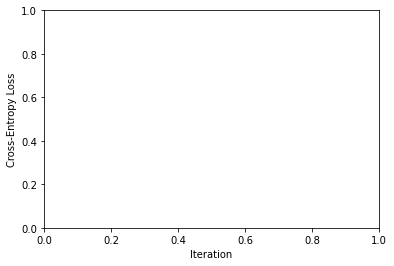

In [16]:
cum = 300
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.plot(
    [sum(loss_history[i:i+cum])/cum for i in range(0, len(loss_history), cum)])

In [17]:
def sample_next(model, x, prev_state, topk=5, uniform=True):
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    
    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix, p=p)
    return sampled_ix, state


def sample(model, seed, topk=5, uniform=True, max_seqlen=18, stop_on=None):
    seed = seed if isinstance(seed, (list, tuple)) else [seed]
    
    model.eval()
    with torch.no_grad():
        sampled_ix_list = seed[:]
        x = torch.tensor([seed])
        
        prev_state = model.init_state(b_size=1)
        for t in range(max_seqlen - len(seed)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)

            sampled_ix_list.append(sampled_ix)
            x = torch.tensor([[sampled_ix]])
            
            if sampled_ix==stop_on:
                break
    
    model.train()
    return sampled_ix_list

In [18]:
print(">>> Samples where seed is a randomly chosen character.")
for i in range(10):
    seed = random.choice(list(char_to_ix.values())[1:])
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))


print(">>> Samples where seed is a list of character.")
for i in range(3):
    seed = keys_to_values(list("python"), char_to_ix, char_to_ix["<PAD>"])
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

>>> Samples where seed is a randomly chosen character.
25 => yroctosaurus<EOS>
9 => ingonosaurus<EOS>
4 => dachodongosaurus<EOS>
17 => qilambeititan<EOS>
15 => oligosaurus<EOS>
9 => iliovenator<EOS>
8 => hyposaurus<EOS>
22 => velasuchus<EOS>
10 => jongongosaurus<EOS>
26 => ziaosaurus<EOS>
>>> Samples where seed is a list of character.


KeyError: '<PAD>'

# GRU name generator with file input

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import numpy as np
import os.path

# Seed random
np.random.seed(0)

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

data_in = open('input0.txt', 'r').read().lower()
training_data = data_in.split(' ')

char_vocab = ["<EOS>", " "] + sorted([ch for ch in string.ascii_lowercase])
char_size = len(char_vocab)
char_to_ix = {ch:i for i, ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch, i in char_to_ix.items()}            

word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for word in training_data:
    if word not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)

{'sales': 0, 'cast': 1, 'podcast': 2, 'pod': 3, 'mentori': 4, 'mentor': 5, 'polyvalence': 6, 'tanyo': 7, 'helpbit': 8, 'castastic': 9, 'fantastic': 10, 'fan': 11, 'castiller': 12, 'destill': 13, 'optimize': 14, 'help': 15, 'learn': 16, 'educate': 17, 'rep': 18, 'assist': 19, 'train': 20, '': 21}


In [60]:
def one_hot_seq(input_seq, vocab_len):
    x = torch.zeros([1, len(input_seq), vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    for t in range(len(input_seq)):
        x[0][t][char_to_ix[input_seq[t]]] = 1
    return x

def one_hot_char(input_char, vocab_len):
    x = torch.zeros([1, 1, vocab_len], dtype=torch.float)  # dtype=torch.float  dtype=torch.long
    x[0][0][char_to_ix[input_char]] = 1
    return x
    
print(char_vocab)

print(one_hot_seq('brown', len(char_vocab)))
            
print(one_hot_char('b', len(char_vocab)))

EMBEDDING_DIM = len(char_vocab)
HIDDEN_DIM = 6

['<EOS>', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [61]:
class GRUCreator(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, char_size):  # input dimension need to be (batch_size, seq_len, input_size)
        super(GRUCreator, self).__init__()
        self.hidden_dim = hidden_dim

        #self.word_embeddings = nn.Embedding(char_size, embedding_dim)  # lookup table that stores embeddings of a fixed dict and size
        #self.gru = nn.GRU(embedding_dim, hidden_dim)  # GRU: input_size, hidden, num_layers
        self.gru = nn.GRU(embedding_dim, embedding_dim)  # requires float inputs (so without embeddings need to cast to float)

        # The linear layer that maps from hidden state space to vocabulary space
        #self.hidden2char = nn.Linear(hidden_dim, char_size)

    def forward(self, inpt):
        #embeds = self.word_embeddings(inpt)
        #print(inpt.size(), embeds.size())
        #gru_out, _ = self.gru(embeds.view(1, 1, len(inpt)))  # embeds.view(len(sentence), 1, -1)
        #print(inpt.dtype, inpt.size(), inpt)
        gru_out, _ = self.gru(inpt)
        #inpt_space = self.hidden2char(gru_out.view(len(inpt), -1))
        #inpt_scores = F.log_softmax(inpt_space, dim=1)
        #return inpt_scores
        return gru_out

In [65]:
model = GRUCreator(EMBEDDING_DIM, HIDDEN_DIM, len(char_vocab))
#loss_function = nn.NLLLoss()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

ix_to_word = { w:i for i, w in enumerate(word_to_ix) }

'''with torch.no_grad():
    for word in training_data:
        for char in word:
            inputs = one_hot_char(char, len(char_vocab))
            #print(inputs.dtype, inputs.size(), inputs)
            outpt = model(inputs)
            print(outpt)'''

for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for word in training_data:
        model.zero_grad()
        
        inputs = one_hot_seq(word, len(char_vocab))
        targets = one_hot_seq(word, len(char_vocab))

        word_scores = model(inputs)

        loss = loss_function(word_scores, targets)
        loss.backward()
        optimizer.step()
            
# See what the scores are after training
with torch.no_grad():
    res = []
    for word in training_data:
        inputs = one_hot_seq(word, len(char_vocab))
        outpt = model(inputs)
        top_value, top_idx = outpt.topk(1)  # chose top value from scores (returned as value, idx)
        for i in top_idx[0]:
            res.append(ix_to_char[i.item()])
                
    print(''.join(res))

salescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdestillapticipelelplearnedecaterepassisttrainsalescastpadcastpadcentaricentarpaltaalencetantalelpaitcastasticaantasticaancastillerdesti

In [66]:
# generate new words

data_in = input('enter some name ideas:').lower()
new_data = data_in.split(' ')

with torch.no_grad():
    res = []
    for word in new_data:
        inputs = one_hot_seq(word, len(char_vocab))
        outpt = model(inputs)
        top_value, top_idx = outpt.topk(1)  # chose top value from scores (returned as value, idx)
        for i in top_idx[0]:
            res.append(ix_to_char[i.item()])
                
    print(''.join(res))

enter some name ideas:cast test model name fantasy
casttestcadelnaceaantast
